# Modelling - Abalone Age Prediction

Ce notebook implémente un modèle de régression pour prédire l'âge des abalones (nombre de rings).

**Approche :**
- Modèle de régression linéaire simple
- Tracking des expériences avec MLflow
- Évaluation avec plusieurs métriques

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import mlflow
import mlflow.sklearn

# Set MLflow experiment
mlflow.set_experiment("abalone-age-prediction")


<Experiment: artifact_location='file:///c:/Users/thiba/PythonDSB2A/artefact/project/xhec-mlops-2025-project/notebooks/mlruns/803367546062592902', creation_time=1761219270163, experiment_id='803367546062592902', last_update_time=1761219270163, lifecycle_stage='active', name='abalone-age-prediction', tags={}>

## 1. Chargement des données


In [34]:
# Load dataset
df = pd.read_csv("../data/abalone.csv")
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## 2. Préparation des données


In [35]:
# Encode categorical variable (Sex)
le = LabelEncoder()
df['Sex_encoded'] = le.fit_transform(df['Sex'])

# Separate features and target
X = df.drop(['Rings', 'Sex'], axis=1)
y = df['Rings']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")


Features shape: (4177, 8)
Target shape: (4177,)

Features: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_encoded']


In [36]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 3341
Test set size: 836


## 3. Entraînement du modèle avec MLflow


In [37]:
# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Start MLflow run
with mlflow.start_run(run_name="linear_regression_baseline"):
    # Log parameters
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)

    # Log metrics
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)

    # Log model
    mlflow.sklearn.log_model(model, "model")

# Print metrics
print("Model Performance:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


2025/10/23 13:54:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 13:54:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/23 13:54:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model Performance:
Train RMSE: 2.2067
Test RMSE: 2.2500
Train MAE: 1.6037
Test MAE: 1.6306
Train R²: 0.5265
Test R²: 0.5323


## 4. Visualisation des résultats


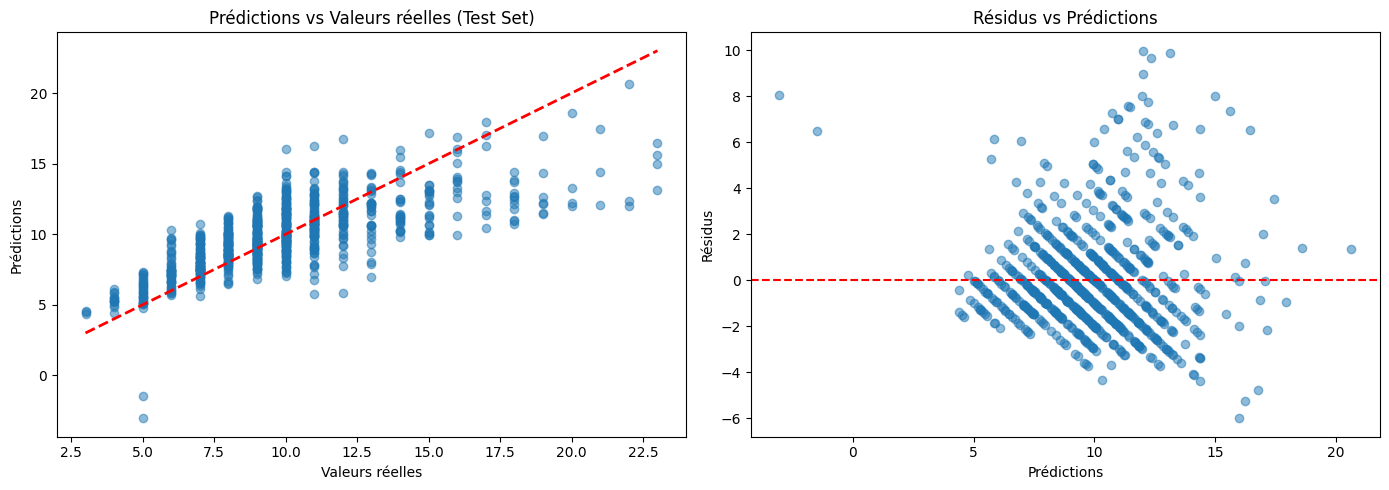

In [38]:
# Predictions vs Actual values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles (Test Set)')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Résidus vs Prédictions')

plt.tight_layout()
plt.show()


---

## 6. Amélioration du modèle

### 6.1 Feature Engineering

Nous allons créer des features supplémentaires pour capturer les relations non-linéaires :
- Ratios entre les différentes mesures de poids
- Interactions entre dimensions physiques
- Features polynomiales


In [39]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# Create enhanced features
def create_features(df_input):
    """Create engineered features from the original dataset"""
    df_feat = df_input.copy()

    # Encode Sex if not already done
    if 'Sex' in df_feat.columns:
        le = LabelEncoder()
        df_feat['Sex_encoded'] = le.fit_transform(df_feat['Sex'])
        df_feat = df_feat.drop('Sex', axis=1)

    # Volume approximation (assuming ellipsoid shape)
    df_feat['Volume'] = df_feat['Length'] * df_feat['Diameter'] * df_feat['Height']

    # Density approximations
    df_feat['Density'] = df_feat['Whole weight'] / (df_feat['Volume'] + 1e-6)

    # Weight ratios
    df_feat['Shucked_ratio'] = df_feat['Shucked weight'] / (df_feat['Whole weight'] + 1e-6)
    df_feat['Viscera_ratio'] = df_feat['Viscera weight'] / (df_feat['Whole weight'] + 1e-6)
    df_feat['Shell_ratio'] = df_feat['Shell weight'] / (df_feat['Whole weight'] + 1e-6)

    # Aspect ratios
    df_feat['Length_Diameter_ratio'] = df_feat['Length'] / (df_feat['Diameter'] + 1e-6)
    df_feat['Height_Diameter_ratio'] = df_feat['Height'] / (df_feat['Diameter'] + 1e-6)

    # Surface area approximation
    df_feat['Surface_area'] = df_feat['Length'] * df_feat['Diameter']

    return df_feat

# Apply feature engineering
df_enhanced = create_features(df)

# Separate features and target
X_enhanced = df_enhanced.drop(['Rings'], axis=1)
y_enhanced = df_enhanced['Rings']

# Split data
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

print(f"Enhanced features: {X_enhanced.shape[1]} features")
print(f"New features: {X_enhanced.columns.tolist()}")
print(f"\nTraining set: {X_train_enh.shape}")
print(f"Test set: {X_test_enh.shape}")


Enhanced features: 16 features
New features: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_encoded', 'Volume', 'Density', 'Shucked_ratio', 'Viscera_ratio', 'Shell_ratio', 'Length_Diameter_ratio', 'Height_Diameter_ratio', 'Surface_area']

Training set: (3341, 16)
Test set: (836, 16)


### 6.2 Random Forest Regressor

Random Forest est un modèle d'ensemble qui peut capturer des relations non-linéaires et des interactions complexes entre features.


In [40]:
# Train Random Forest with default parameters first
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_enh, y_train_enh)

# Make predictions
y_pred_train_rf = rf_model.predict(X_train_enh)
y_pred_test_rf = rf_model.predict(X_test_enh)

# Calculate metrics
train_rmse_rf = np.sqrt(mean_squared_error(y_train_enh, y_pred_train_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test_enh, y_pred_test_rf))
train_mae_rf = mean_absolute_error(y_train_enh, y_pred_train_rf)
test_mae_rf = mean_absolute_error(y_test_enh, y_pred_test_rf)
train_r2_rf = r2_score(y_train_enh, y_pred_train_rf)
test_r2_rf = r2_score(y_test_enh, y_pred_test_rf)

# Log to MLflow
with mlflow.start_run(run_name="random_forest_enhanced_features"):
    # Log parameters
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("feature_engineering", "Yes")
    mlflow.log_param("n_features", X_enhanced.shape[1])

    # Log metrics
    mlflow.log_metric("train_rmse", train_rmse_rf)
    mlflow.log_metric("test_rmse", test_rmse_rf)
    mlflow.log_metric("train_mae", train_mae_rf)
    mlflow.log_metric("test_mae", test_mae_rf)
    mlflow.log_metric("train_r2", train_r2_rf)
    mlflow.log_metric("test_r2", test_r2_rf)

    # Log model
    mlflow.sklearn.log_model(rf_model, "model")

# Print results
print("Random Forest Performance (Enhanced Features):")
print(f"Train RMSE: {train_rmse_rf:.4f} (vs Baseline: {train_rmse:.4f})")
print(f"Test RMSE: {test_rmse_rf:.4f} (vs Baseline: {test_rmse:.4f})")
print(f"Train MAE: {train_mae_rf:.4f} (vs Baseline: {train_mae:.4f})")
print(f"Test MAE: {test_mae_rf:.4f} (vs Baseline: {test_mae:.4f})")
print(f"Train R²: {train_r2_rf:.4f} (vs Baseline: {train_r2:.4f})")
print(f"Test R²: {test_r2_rf:.4f} (vs Baseline: {test_r2:.4f})")
print(f"\nImprovement in Test RMSE: {((test_rmse - test_rmse_rf) / test_rmse * 100):.2f}%")
print(f"Improvement in Test R²: {((test_r2_rf - test_r2) / test_r2 * 100):.2f}%")


2025/10/23 13:54:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 13:55:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/23 13:55:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Performance (Enhanced Features):
Train RMSE: 0.7864 (vs Baseline: 2.2067)
Test RMSE: 2.1500 (vs Baseline: 2.2500)
Train MAE: 0.5629 (vs Baseline: 1.6037)
Test MAE: 1.5328 (vs Baseline: 1.6306)
Train R²: 0.9399 (vs Baseline: 0.5265)
Test R²: 0.5730 (vs Baseline: 0.5323)

Improvement in Test RMSE: 4.44%
Improvement in Test R²: 7.64%


### 6.3 Importance des features

Analysons quelles features contribuent le plus à la prédiction.


Top 10 Most Important Features:
                  feature  importance
6            Shell weight    0.401583
10          Shucked_ratio    0.213669
11          Viscera_ratio    0.048528
14  Height_Diameter_ratio    0.043075
13  Length_Diameter_ratio    0.042909
12            Shell_ratio    0.042086
9                 Density    0.033676
8                  Volume    0.026587
5          Viscera weight    0.025376
3            Whole weight    0.022875


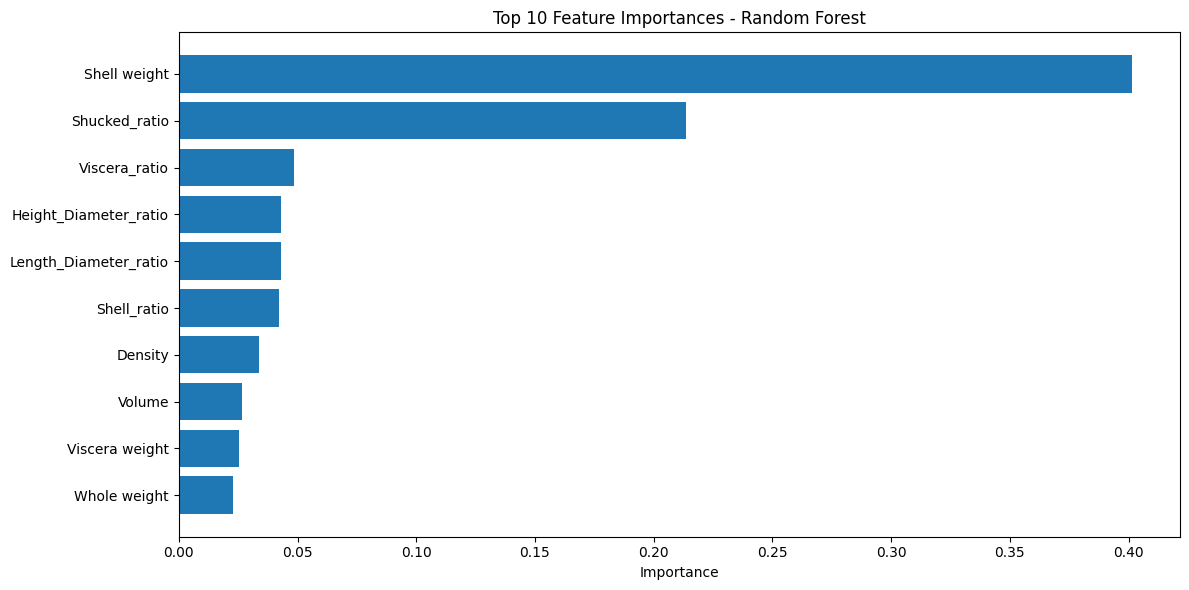

In [41]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['feature'][:10][::-1], feature_importance['importance'][:10][::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


### 6.4 Optimisation des hyperparamètres

In [ ]:
# Define parameter grid (réduit pour éviter un temps d'exécution trop long)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Starting GridSearchCV...")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
print("Note: Sur Windows avec Jupyter, n_jobs=1 pour éviter les erreurs de sérialisation")

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=1),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=2
)


grid_search.fit(X_train_enh, y_train_enh)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")


Starting GridSearchCV...
Total combinations: 16
Note: Sur Windows avec Jupyter, n_jobs=1 pour éviter les erreurs de sérialisation
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.5s
[

In [43]:
# Get best model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_test_opt = best_rf_model.predict(X_test_enh)

# Calculate metrics
test_rmse_opt = np.sqrt(mean_squared_error(y_test_enh, y_pred_test_opt))
test_mae_opt = mean_absolute_error(y_test_enh, y_pred_test_opt)
test_r2_opt = r2_score(y_test_enh, y_pred_test_opt)

# Log to MLflow
with mlflow.start_run(run_name="random_forest_optimized"):
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("feature_engineering", "Yes")
    mlflow.log_param("hyperparameter_tuning", "GridSearchCV")
    for param, value in grid_search.best_params_.items():
        mlflow.log_param(param, value)

    mlflow.log_metric("test_rmse", test_rmse_opt)
    mlflow.log_metric("test_mae", test_mae_opt)
    mlflow.log_metric("test_r2", test_r2_opt)

    mlflow.sklearn.log_model(best_rf_model, "model")

print("\nOptimized Random Forest Performance:")
print(f"Test RMSE: {test_rmse_opt:.4f} (Baseline: {test_rmse:.4f}, RF Default: {test_rmse_rf:.4f})")
print(f"Test R²: {test_r2_opt:.4f} (Baseline: {test_r2:.4f}, RF Default: {test_r2_rf:.4f})")
print(f"\nTotal improvement vs Baseline: {((test_rmse - test_rmse_opt) / test_rmse * 100):.2f}% RMSE reduction")


2025/10/23 14:01:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/23 14:01:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/23 14:01:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Optimized Random Forest Performance:
Test RMSE: 2.1283 (Baseline: 2.2500, RF Default: 2.1500)
Test R²: 0.5816 (Baseline: 0.5323, RF Default: 0.5730)

Total improvement vs Baseline: 5.41% RMSE reduction


### 6.5 Comparaison visuelle des modèles


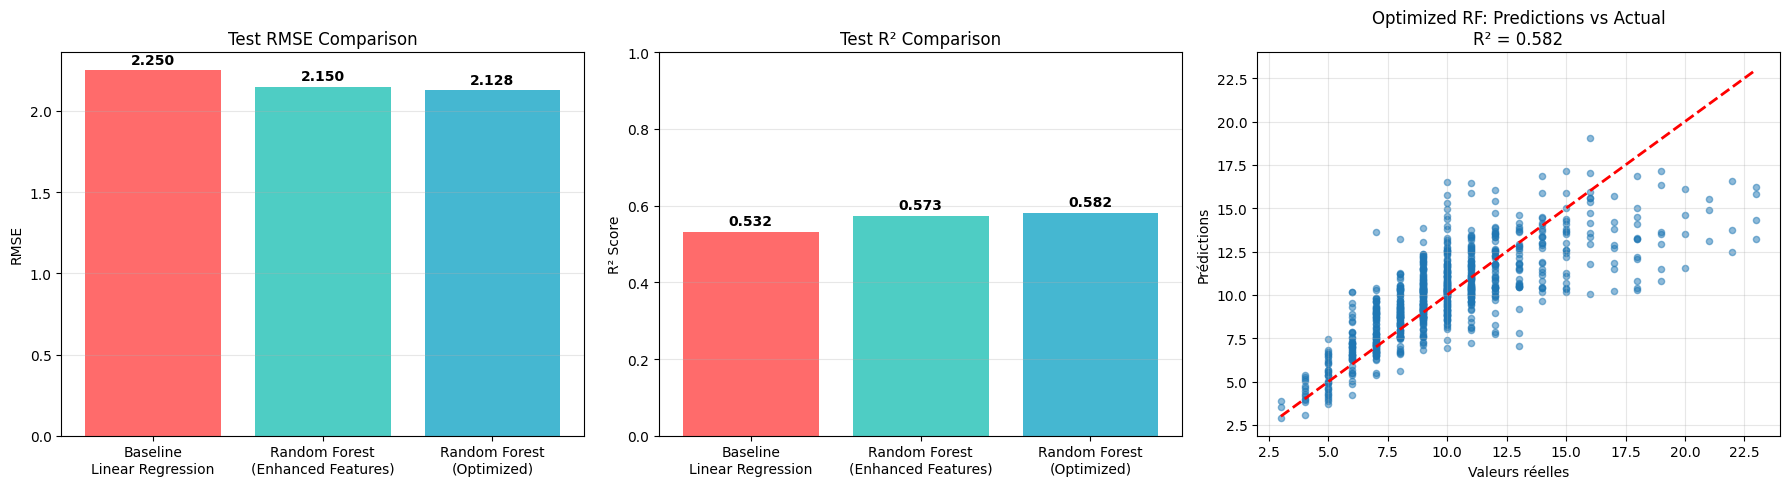

In [44]:
# Comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Baseline\nLinear Regression', 'Random Forest\n(Enhanced Features)', 'Random Forest\n(Optimized)']
rmse_values = [test_rmse, test_rmse_rf, test_rmse_opt]
r2_values = [test_r2, test_r2_rf, test_r2_opt]

# RMSE comparison
axes[0].bar(models, rmse_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_ylabel('RMSE')
axes[0].set_title('Test RMSE Comparison')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# R² comparison
axes[1].bar(models, r2_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('R² Score')
axes[1].set_title('Test R² Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Predictions vs Actual (Optimized model)
axes[2].scatter(y_test_enh, y_pred_test_opt, alpha=0.5, s=20)
axes[2].plot([y_test_enh.min(), y_test_enh.max()], [y_test_enh.min(), y_test_enh.max()], 'r--', lw=2)
axes[2].set_xlabel('Valeurs réelles')
axes[2].set_ylabel('Prédictions')
axes[2].set_title(f'Optimized RF: Predictions vs Actual\nR² = {test_r2_opt:.3f}')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()
